# TM10007 Assignment lipomas G9

In [63]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/Machine-Learning-TM10007-G9/Lipo-MRI.git

  Preparing metadata (setup.py) ... done


# **Data loading**



In [64]:
from worclipo.load_data import load_data
data = load_data()

#Show the number of samples (patients) and columns (features).
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 115
The number of columns: 494


# **Import important functions**

In [65]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn


# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from collections import Counter

# **Create X and Y**

In [66]:
# X and y are created
X = data.iloc[:, 1:].values
y = np.array(data['label'])

# Show the distribution of lipomas and liposarcomas in the dataset
class_counts = Counter(y)

for class_label, count in class_counts.items():
    print(f"Class '{class_label}': {count} samples")

Class 'liposarcoma': 58 samples
Class 'lipoma': 57 samples


# **Split the data**

In [67]:
# Split the X and y variables into a test set (20%) and train set (80%)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=0)

# **Check for missing values**



In [68]:
missing_values = np.sum(np.isnan(X_train))

print("Number of missing values:",missing_values)

Number of missing values: 0


# **Checks if all the data points are floats**

In [69]:
non_floats = 0
for row in X_train:
  for col in row:
    if not isinstance(col, float):
        non_floats += 1

if non_floats == 0:
  print("All values in the dataset are floats")
else:
  print(f"{non_floats} values in dataset are not floats")

All values in the dataset are floats


# **Check for duplicates**

In [70]:
# Find duplicate columns
def delete_duplicate_columns(arr):
    num_cols = arr.shape[1]
    duplicate_columns = []
    for i in range(num_cols):
        for j in range(i + 1, num_cols):
            if np.array_equal(arr[:, i], arr[:, j]):
                duplicate_columns.append(j)  # Append index of the duplicate column
    if duplicate_columns:
        # Delete duplicate columns
        arr_without_duplicates = np.delete(arr, duplicate_columns, axis=1)
        return arr_without_duplicates, duplicate_columns
    else:
        return arr, []

# Remove duplicate columns
X_train_clean, deleted_indices = delete_duplicate_columns(X_train)

print("Number of columns in original array:",X_train.shape[1])
print("Number of columns after removal of duplicate columns:",X_train_clean.shape[1])

Number of columns in original array: 493
Number of columns after removal of duplicate columns: 465


# **Checking for outliers**
Outliers are found using the Z-score. A datapoint with a Z-score of 3 or higher or -3 or lower is considered an outlier.

In [71]:
num_rows, num_cols = X_train_clean.shape
total_outliers = 0

for i in range(num_cols):
    z = np.abs(stats.zscore(X_train_clean[:,i]))

    threshold = 3
    outliers = X_train_clean[z > threshold, i]
    total_outliers +=(len(outliers))

print(f'Total number of outliers  = {total_outliers}/{num_rows*num_cols}')
print(f'Average number of outliers per feature = {round(total_outliers/num_cols,2)}/{num_rows}')


Total number of outliers  = 661/42780
Average number of outliers per feature = 1.42/92


# **Check if the data is normally distributed**
To check if the data is normally distributed the Kolmogorov Smirnov test is used with a threshold of 0.05.

In [72]:
total_not_normal = 0
p_threshold = 0.05

for l in range(num_cols):
    kstest_result = stats.kstest(X_train_clean[:,l], 'norm')
    if kstest_result.pvalue < p_threshold:
        total_not_normal += 1

print(f'Total features that are not normally distributed = {total_not_normal}/{num_cols}')


Total features that are not normally distributed = 464/465


# **Scaling**
To scale the data the RobustScaler is used, because there are outliers in the data and the data has a non Gaussian distribution.

In [73]:
# Scale the data to be normal
scaler = preprocessing.RobustScaler()
scaler.fit(X_train_clean)
X_train_scaled = scaler.transform(X_train_clean)

# **Finding important features**

To find the importance of the different features in the dataset a plot is made that ranks the 20 most important features from most important to least important.

Feature ranking:


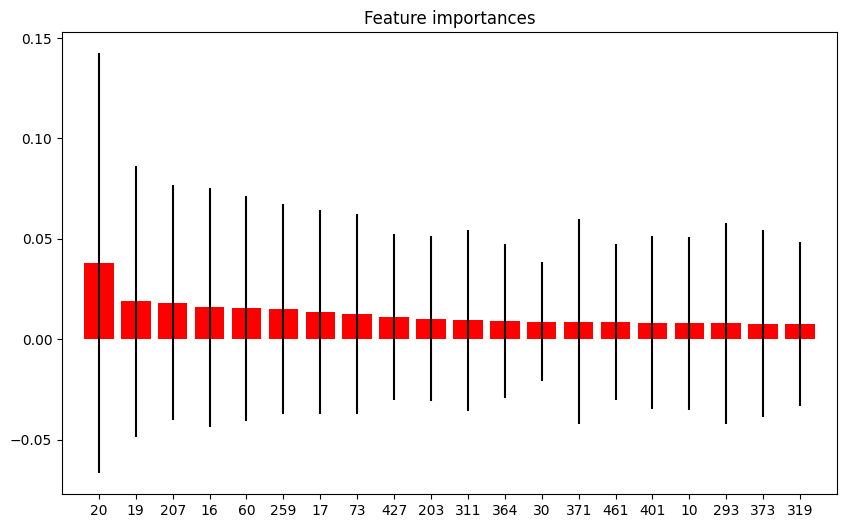

In [74]:
forest = RandomForestClassifier(n_estimators=100, random_state = 42)

forest.fit(X_train_scaled, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

#for f in range(X_train_scaled.shape[1]):
    #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest for the first 20 features
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(20), importances[indices][:20],
       color="r", yerr=std[indices][:20], align="center")
plt.xticks(range(20), indices[:20])
plt.xlim([-1, 20])
plt.show()

# **Feature selection**
For feature selection the L1-regularization is used, because it can handle high dimensionality, it migigates overfitting and is easy to interpret

In [75]:
print("Original data shape:",X_train_scaled.shape)
clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
lsvc = LogisticRegression(C=0.5, penalty="l1", dual=False, solver='liblinear', random_state=42).fit(X_train_scaled, y_train)
model = SelectFromModel(lsvc, prefit=True)
X_feature = model.transform(X_train_scaled)
print("New data shape:",X_feature.shape)

Original data shape: (92, 465)
New data shape: (92, 35)


# **PCA**
A PCA was done to further extract features, however, after seeing the results of the PCA this part was excluded from the methods.

In [76]:
# Voer PCA uit
pca = decomposition.PCA(n_components=10)  #n_components is the amount of features that remain after PCA (can also be a ratio)
X_pca = pca.fit_transform(X_feature)

# Verklaarde variantie ratio's
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulatieve verklaarde variantie
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Maak een DataFrame om de resultaten mooi weer te geven
df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance_ratio))],
    'Explained Variance Ratio': explained_variance_ratio,
    'Cumulative Explained Variance': cumulative_explained_variance
})

print(df)

  Principal Component  Explained Variance Ratio  Cumulative Explained Variance
0                 PC1                  0.959569                       0.959569
1                 PC2                  0.025063                       0.984632
2                 PC3                  0.008762                       0.993394
3                 PC4                  0.003388                       0.996781
4                 PC5                  0.002585                       0.999366
5                 PC6                  0.000268                       0.999634
6                 PC7                  0.000236                       0.999870
7                 PC8                  0.000056                       0.999926
8                 PC9                  0.000047                       0.999973
9                PC10                  0.000024                       0.999997


# **Random Forest Classifier**


In [77]:
# Initialize KFold cross-validator
loo = LeaveOneOut()

scores_rfc = []
# Iterate over each fold
for train_index, val_index in loo.split(X_feature, y_train):
    # Split data into train and validation sets for this fold
    X_train_fold, X_val_fold = X_feature[train_index], X_feature[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    rfc = RandomForestClassifier(n_estimators=100, random_state=42)
    rfc.fit(X_train_fold,y_train_fold)
    pred_rfc = rfc.predict(X_val_fold)
    accuracy_rfc = accuracy_score(y_val_fold, pred_rfc)

    # Append accuracy to scores list
    scores_rfc.append(accuracy_rfc)

# Print the accuracy scores for each fold
print("Accuracy scores for each fold:", scores_rfc)

# Calculate and print the average accuracy across all folds
average_accuracy_rfc = sum(scores_rfc) / len(scores_rfc)
print("Average Accuracy:", average_accuracy_rfc)

Accuracy scores for each fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Average Accuracy: 0.7608695652173914


# **Grid Search of the Random Forest Classifier**

In [78]:
loo = LeaveOneOut()

# Define the parameter grid for grid search
param_grid = {'n_estimators': range(50, 200, 10),}  # Number of trees

# Initialize Random Forest classifier
rfc = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=loo, scoring='accuracy')

# Fit the GridSearchCV to the data
grid_search.fit(X_feature, y_train)

# Get the best estimator from grid search
best_rfc = grid_search.best_estimator_

# Get the best parameters from grid search
best_params = grid_search.best_params_

# Get the best score from grid search
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'n_estimators': 60}
Best Score: 0.7717391304347826


# **Support Vector Machine**

In [79]:
# Initialize KFold cross-validator
loo = LeaveOneOut()

scores_clf = []
# Iterate over each fold
for train_index, val_index in loo.split(X_feature, y_train):
    # Split data into train and validation sets for this fold
    X_train_fold, X_val_fold = X_feature[train_index], X_feature[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    clf = svm.SVC()
    clf.fit(X_train_fold,y_train_fold)
    pred_clf = clf.predict(X_val_fold)
    accuracy_clf = accuracy_score(y_val_fold, pred_clf)

    # Append accuracy to scores list
    scores_clf.append(accuracy_clf)

# Print the accuracy scores for each fold
print("Accuracy scores for each fold:", scores_clf)

# Calculate and print the average accuracy across all folds
average_accuracy_clf = sum(scores_clf) / len(scores_clf)
print("Average Accuracy:", average_accuracy_clf)

Accuracy scores for each fold: [1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
Average Accuracy: 0.532608695652174


# **Grid Search of the Support Vector Machine**

In [80]:
# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],                      # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],    # Kernel type
}

# Initialize SVM classifier
svc = svm.SVC()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=loo, scoring='accuracy')

# Fit the GridSearchCV to the data
grid_search.fit(X_feature, y_train)

# Get the best estimator from grid search
best_svc = grid_search.best_estimator_

# Get the best parameters from grid search
best_params = grid_search.best_params_

# Get the best score from grid search
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'C': 0.1, 'kernel': 'linear'}
Best Score: 0.7934782608695652


# **Neural Network (Multi-Layer Perceptron Classifier)**

In [81]:
# Initialize KFold cross-validator
loo = LeaveOneOut()

scores_mlpc = []
# Iterate over each fold
for train_index, val_index in loo.split(X_feature, y_train):
    # Split data into train and validation sets for this fold
    X_train_fold, X_val_fold = X_feature[train_index], X_feature[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    mlpc = MLPClassifier(hidden_layer_sizes=(50,50),max_iter=500, random_state=42)
    mlpc.fit(X_train_fold, y_train_fold)
    pred_mlpc = mlpc.predict(X_val_fold)
    accuracy_mlpc = accuracy_score(y_val_fold, pred_mlpc)

    # Append accuracy to scores list
    scores_mlpc.append(accuracy_mlpc)

# Print the accuracy scores for each fold
print("Accuracy scores for each fold:", scores_mlpc)

# Calculate and print the average accuracy across all folds
average_accuracy_mlpc = sum(scores_mlpc) / len(scores_mlpc)
print("Average Accuracy:", average_accuracy_mlpc)

Accuracy scores for each fold: [0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
Average Accuracy: 0.5978260869565217


# **Grid Search of the Multi-Layer Perceptron Classifier**

In [82]:
# Define the parameter grid for grid search
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],  # Number of neurons in each hidden layer
    'activation': ['relu', 'tanh', 'logistic'],        # Activation function
    'learning_rate': ['constant', 'adaptive'],      # Learning rate schedule
    'early_stopping': [True]
}

# Initialize MLPClassifier
mlp = MLPClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=loo, scoring='accuracy')

# Fit the GridSearchCV to the data
grid_search.fit(X_feature, y_train)

# Get the best estimator from grid search
best_mlp = grid_search.best_estimator_

# Get the best parameters from grid search
best_params = grid_search.best_params_

# Get the best score from grid search
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'activation': 'tanh', 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive'}
Best Score: 0.6739130434782609


# **Learning curve random forest**

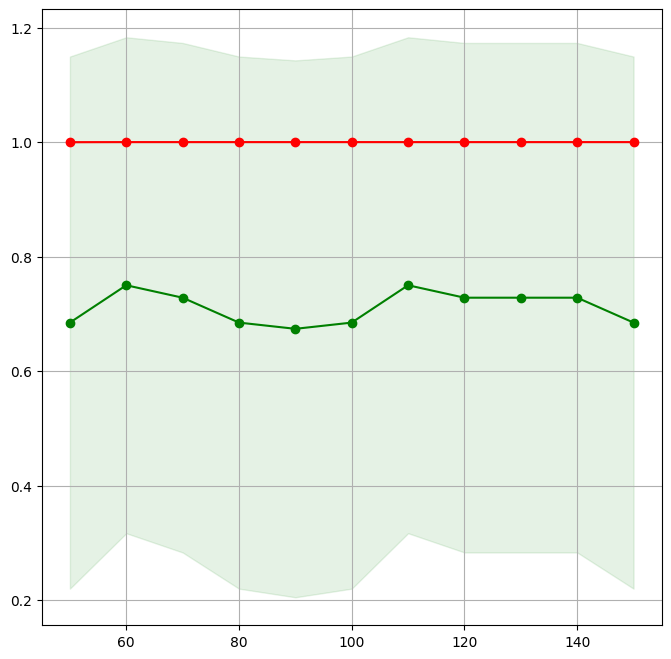

In [83]:
n_est_list = list(range(50,160,10))

all_train = []
all_test = []

# Repeat the experiment 20 times, use 20 random splits in which class balance is retained
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
loo = LeaveOneOut()

for train_index, test_index in loo.split(X_feature, y_train):
    train_scores = []
    test_scores = []

    split_X_train = X_train_scaled[train_index]
    split_y_train = y_train[train_index]
    split_X_test = X_train_scaled[test_index]
    split_y_test = y_train[test_index]

    for k in n_est_list:
        rfc = RandomForestClassifier(n_estimators= k)
        rfc.fit(split_X_train, split_y_train)

        # Test the classifier on the training data and plot
        score_train = rfc.score(split_X_train, split_y_train)
        score_test = rfc.score(split_X_test, split_y_test)

        train_scores.append(score_train)
        test_scores.append(score_test)

    all_train.append(train_scores)
    all_test.append(test_scores)


# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the mean scores and the std as shading
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(n_est_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(n_est_list, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(n_est_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(n_est_list, test_scores_mean, 'o-', color="g",
        label="Test score")

# **Retraining**

In [84]:
# Initialize the SVM classifier
svm_classifier = svm.SVC(C=0.1, kernel='linear', random_state=42)

# Train the classifier on the entire training data
svm_classifier.fit(X_feature, y_train)

SVC(C=0.1, kernel='linear', random_state=42)

#**Test**

In [86]:
# Check for missing values
missing_values = np.sum(np.isnan(X_test))
print("Number of missing values:",missing_values)

# Checks if all the data points are floats
non_floats = 0
for row in X_test:
  for col in row:
    if not isinstance(col, float):
        non_floats += 1

# Remove duplicate columns
X_test_clean = np.delete(X_test, deleted_indices, axis=1)
print("Number of columns in original array:",X_test.shape[1])
print("Number of columns after removal of duplicate columns:",X_test_clean.shape[1])

# Scaling
X_test_scaled = scaler.transform(X_test_clean)

# Feature selection
X_test_feature =  model.transform(X_test_scaled)
print("New data shape:",X_test_feature.shape)

# Support Vector Machine
pred_test = svm_classifier.predict(X_test_feature)
accuracy_test = accuracy_score(y_test, pred_test)
print(f'The accuracy of the model is: {accuracy_test}')

Number of missing values: 0
Number of columns in original array: 493
Number of columns after removal of duplicate columns: 465
New data shape: (23, 35)
The accuracy of the model is: 0.7391304347826086
